In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm, lognorm, ncx2

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_parquet(r"data/oxford_data.parquet")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.loc[pd.to_datetime('2014-01-01'):pd.to_datetime('2018-06-01')]
df['return'] = np.log(df['close_price']).diff()

In [4]:
daily_returns = df['return'].iloc[1:]
daily_RV = df['rv10'].iloc[1:]

burnin = 252
dt = 1  # Daily

split_index = round(df.shape[0] * 0.82)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

## RV-QLKF

In [5]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.01, 0.002, 0.001, 0.001, 0.001, -0.5]) # kappa, theta, xi, mu, sigma, rho
# 0.0194974349, 0.00108918014, 0.00817043974, 0.0000760274950, 0.00000100000000, -0.499673084
fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.89180D+03    |proj g|=  3.65858D+05

At iterate    1    f= -7.33687D+03    |proj g|=  1.49000D+00

At iterate    2    f= -7.36101D+03    |proj g|=  1.49000D+00

At iterate    3    f= -7.37852D+03    |proj g|=  4.28396D+04

At iterate    4    f= -7.39969D+03    |proj g|=  1.33842D+05

At iterate    5    f= -7.47491D+03    |proj g|=  2.32779D+03

At iterate    6    f= -7.47649D+03    |proj g|=  2.61464D+04

At iterate    7    f= -7.47662D+03    |proj g|=  7.79672D+03

At iterate    8    f= -7.49008D+03    |proj g|=  1.50360D+05

At iterate    9    f= -7.49113D+03    |proj g|=  1.06968D+05

At iterate   10    f= -7.49388D+03    |proj g|=  4.43655D+03

At iterate   11    f= -7.49435D+03    |proj g|=  1.51740D+03

At iterate   12    f= -7.49465D+03    |proj g|=  7.18418D+01

At iterate   13    f= -7.4

## QLKF

In [6]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=daily_RV[0], P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.5]) # kappa, theta, xi, mu, rho
# initial_params_returns_corr = np.array([0.02, 0.002, 0.001, 0.001, -0.5]) # kappa, theta, xi, mu, sigma, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17587D+03    |proj g|=  1.60514D+04

At iterate    1    f= -2.24762D+03    |proj g|=  7.84429D+03

At iterate    2    f= -2.24866D+03    |proj g|=  4.79517D+03

At iterate    3    f= -2.32330D+03    |proj g|=  1.01648D+03

At iterate    4    f= -2.32589D+03    |proj g|=  2.76931D+04

At iterate    5    f= -2.32802D+03    |proj g|=  9.21143D+04

At iterate    6    f= -2.32828D+03    |proj g|=  3.11949D+03

At iterate    7    f= -2.32830D+03    |proj g|=  9.83026D+02

At iterate    8    f= -2.32831D+03    |proj g|=  2.79994D+03

At iterate    9    f= -2.32831D+03    |proj g|=  1.49000D+00

At iterate   10    f= -2.32832D+03    |proj g|=  1.25364D+03

At iterate   11    f= -2.32836D+03    |proj g|=  2.94933D+03

At iterate   12    f= -2.32844D+03    |proj g|=  4.89337D+03

At iterate   13    f= -2.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


## PF 

In [7]:
pf_heston_train = PFHeston(train_returns, N=20000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),      # mu
    (4, 6),           # kappa
    (0.01, 0.05),     # theta
    (1, 3),       # xi
    (-0.9, 0),        # rho
    daily_RV[0]       # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 7528.453572261085
resampling since: 14.017841253861624
resampling since: 11.564616403023882
resampling since: 583.7284851174345
resampling since: 717.263435891322
resampling since: 66.12225841273052
resampling since: 1854.6841666435741
resampling since: 6.3440889175519946
resampling since: 102.55513299544519
resampling since: 3410.059909100525
resampling since: 1650.0509959648205
resampling since: 6048.414233126675
resampling since: 5.935960400549672
resampling since: 118.01426533679006
resampling since: 1877.2811032833783
resampling since: 8688.420847887348
resampling since: 10.467703756714965
resampling since: 422.8462261879543
resampling since: 103.13038729655287
resampling since: 63.89286563715041
resampling since: 2695.9550763951984
resampling since: 3.69833323388362
resampling since: 1028.2095498804445
resampling since: 2048.446191139665
resampling since: 499.12450116742286
resampling since: 367.7855688115641
resampling since: 36.19801453241
resampling since: 32

In [8]:
pf_heston_test = PFHeston(test_returns, N=20000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, daily_RV[0]], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 2684.5098135291573
resampling since: 1935.4472338260534
resampling since: 1.2977091082520085
resampling since: 924.2178749790055
resampling since: 364.7043932920344
resampling since: 16.08704962939517
resampling since: 4764.833048646309
resampling since: 2.966883134406397
resampling since: 139.45762274481368
resampling since: 1430.287200685893
resampling since: 1755.859246919083
resampling since: 7359.022342155565
resampling since: 277.9714281938236
resampling since: 265.04224104302205
resampling since: 1713.725669601914
resampling since: 2.5464425826261463
resampling since: 744.2762211618416
resampling since: 32.390984487253185
resampling since: 102.15872622700053
resampling since: 1881.2082674036358
resampling since: 2.1804120282685138
resampling since: 803.6128701618848
resampling since: 870.0623817821668
resampling since: 517.6523764812661
resampling since: 290.40487787519226
resampling since: 1521.9596204644836
resampling since: 26.973502372629902
resampling sinc

In [9]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

## Realized GARCH

In [ ]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

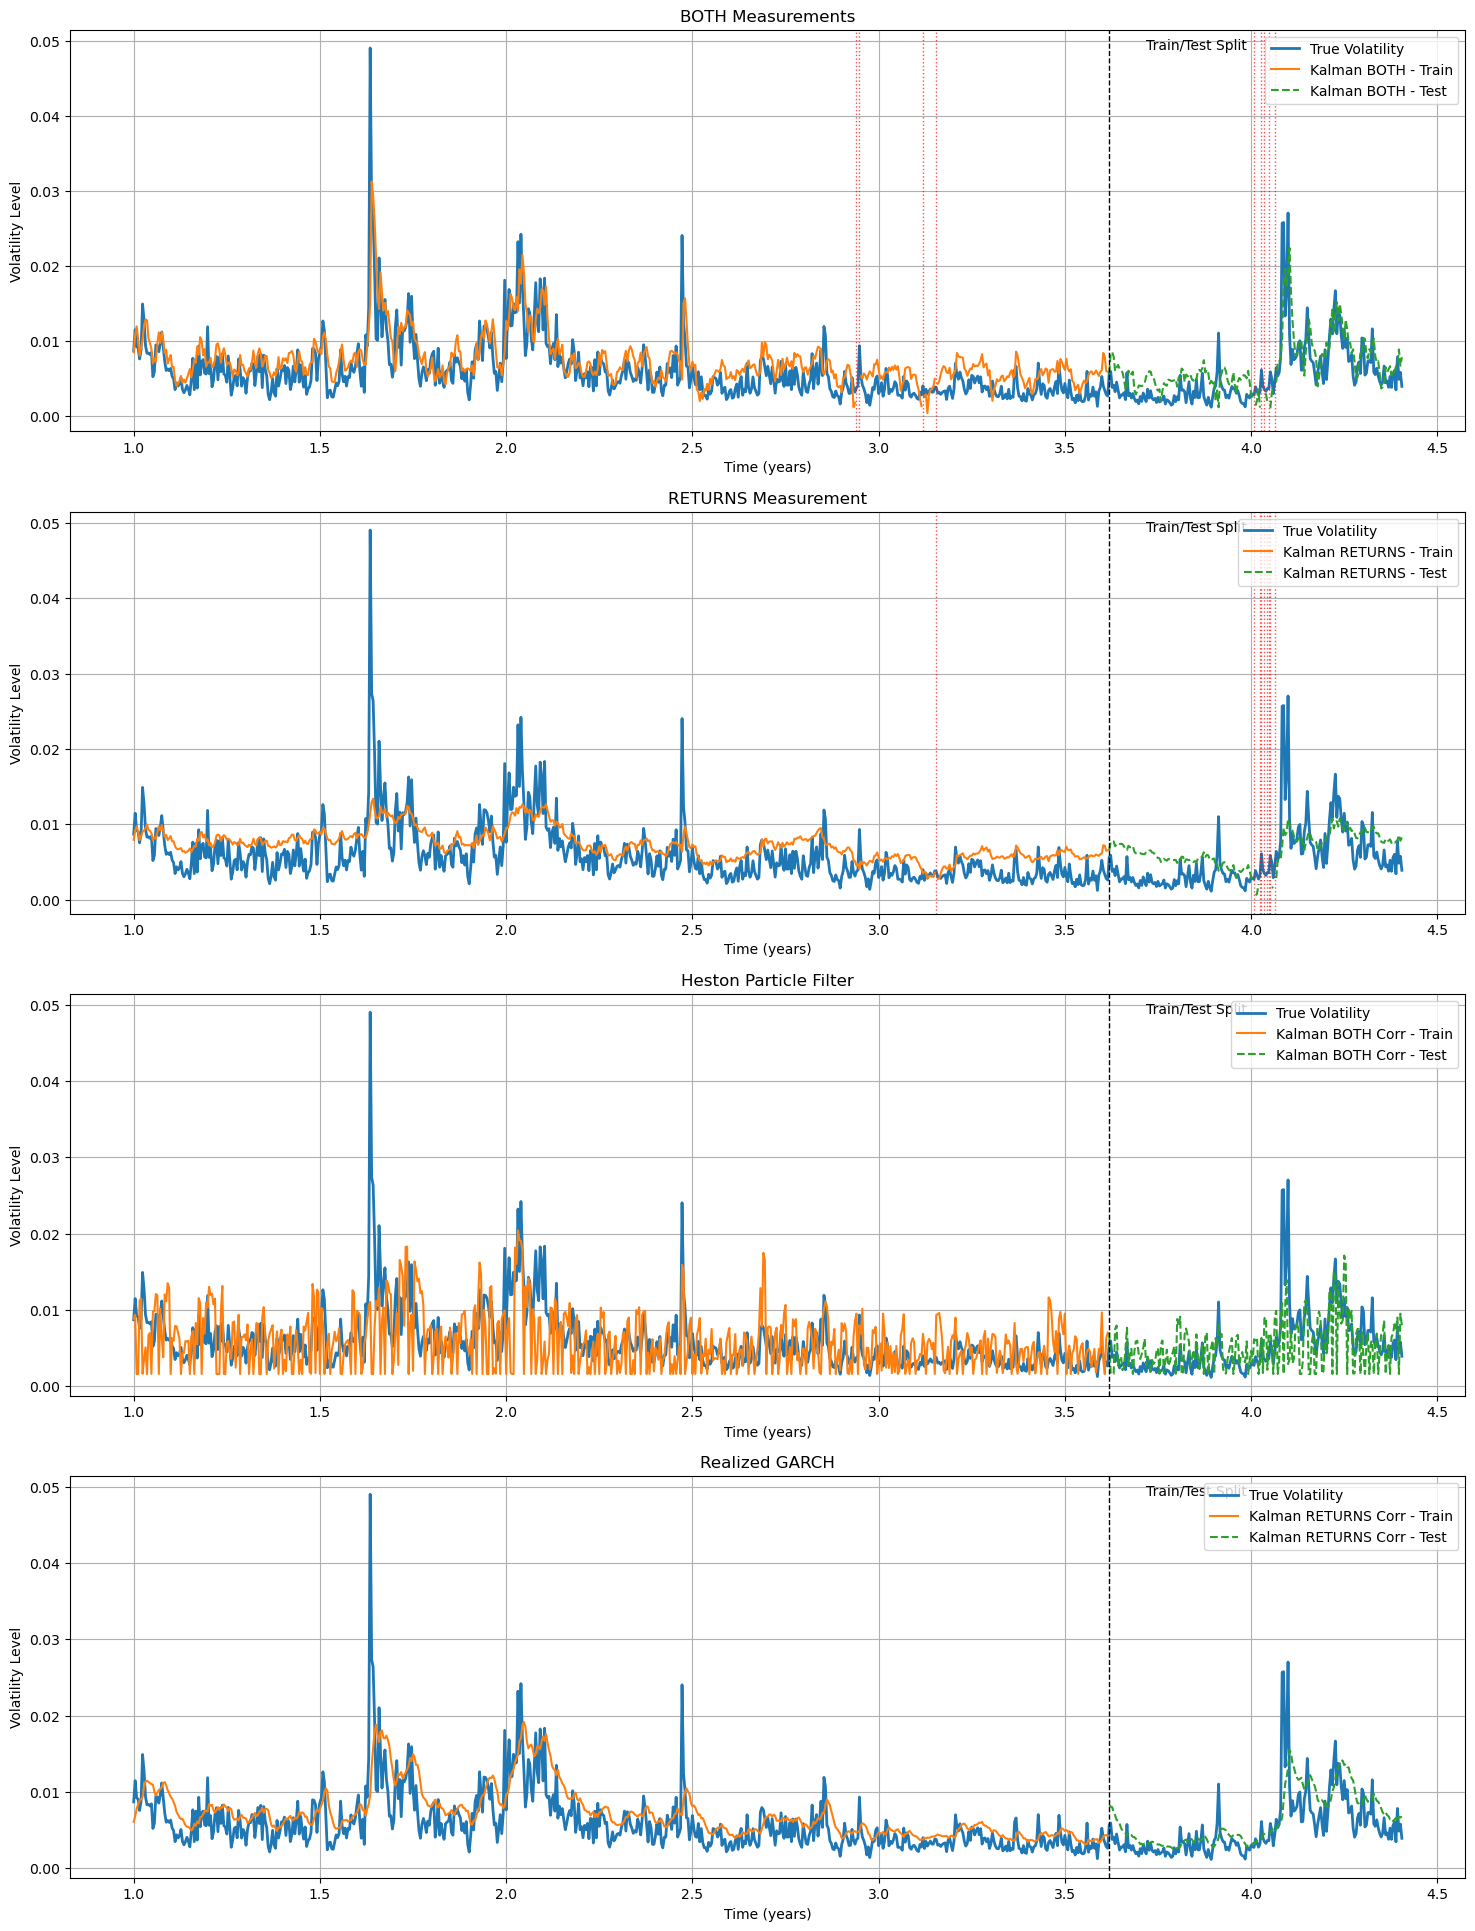

In [23]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

burnin = 252
time_daily = np.arange(len(daily_returns)) / 252
n_filters = len(train_all)
fig, axes = plt.subplots(n_filters, 1, figsize=(18, 6 * n_filters))

for i, ax in enumerate(axes):
    # Slice data
    filt_train = train_all[i][burnin:]
    true_train = daily_RV[burnin:split_index]
    filt_test = test_all[i]
    true_test = daily_RV[split_index:]

    # Sanity checks
    assert len(filt_train) == len(true_train), f"In-sample length mismatch for {titles_all[i]}"
    assert len(filt_test) == len(true_test), f"Out-of-sample length mismatch for {titles_all[i]}"

    # Plot true and predicted volatility
    ax.plot(time_daily[burnin:], np.sqrt(daily_RV[burnin:]), label="True Volatility", lw=2)
    ax.plot(time_daily[burnin:split_index], np.sqrt(filt_train), label=f"{labels_all[i]} - Train", lw=1.5)
    ax.plot(time_daily[split_index:], np.sqrt(filt_test), label=f"{labels_all[i]} - Test", lw=1.5, linestyle="--")

    # Mark the train/test split
    ax.axvline(time_daily[split_index], color='black', linestyle='--', lw=1)
    ax.text(time_daily[split_index] + 0.1, ax.get_ylim()[1]*0.95, 'Train/Test Split', color='black')

    # === Add vertical lines for negative predicted variances ===
    # For train
    neg_train_indices = np.where(np.array(filt_train) < 0)[0]
    for idx in neg_train_indices:
        ax.axvline(time_daily[burnin + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # For test
    neg_test_indices = np.where(np.array(filt_test) < 0)[0]
    for idx in neg_test_indices:
        ax.axvline(time_daily[split_index + idx], color='red', linestyle=':', lw=1, alpha=0.7)

    # Final plot styling
    ax.set_title(f"{titles_all[i]}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Volatility Level")
    ax.legend(loc="upper right")
    ax.grid(True)

In [24]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    # eps = np.finfo(float).eps
    # ratio = y / (h + eps)
    ratio = y / h
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances = daily_RV[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all)):
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    pred_vol = np.sqrt(pred_var)

    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.003064, QLIKE: 1.097724
QLKF               RMSE: 0.003561, QLIKE: 0.893021
PF                 RMSE: 0.004057, QLIKE: 4.056865
Realized GARCH     RMSE: 0.003289, QLIKE: 0.405672


In [ ]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse = ModelConfidenceSet(mse_matrix, n_boot=5000, alpha=0.20, show_progress=True)
mcs_qlike = ModelConfidenceSet(qlike_matrix, n_boot=5000, alpha=0.10, show_progress=True)

mcs_mse.compute()
mcs_qlike.compute()

mcs_mse_results = mcs_mse.results()
mcs_qlike_results = mcs_qlike.results()

Computing MCS: 100%|██████████| 3/3 [00:00<00:00, 1479.47model/s]


In [20]:
mcs_mse_results

,pvalues,status
models,,
3,0.0662,excluded
2,0.1938,included
4,0.5248,included
1,1.0000,included


In [21]:
mcs_qlike_results

,pvalues,status
models,,
3,0.0896,excluded
1,0.1098,included
2,0.1098,included
4,1.0000,included


# Distribution of RV

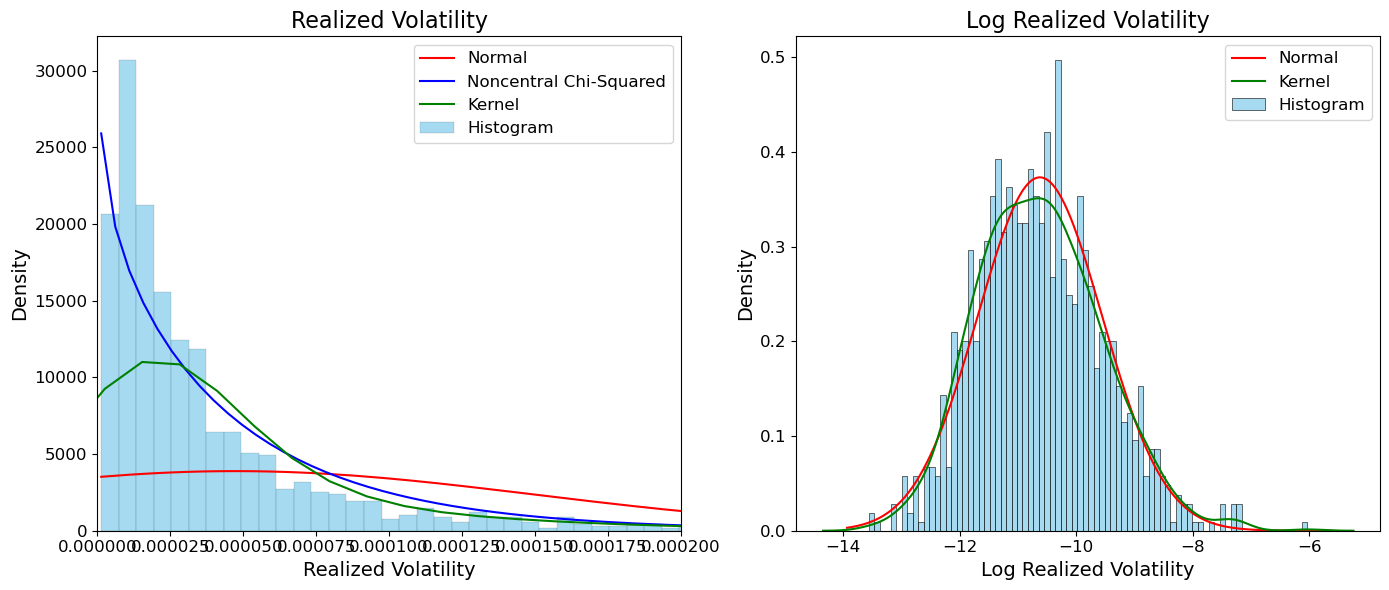

In [20]:
# Prepare data
rv = df['rv10'].dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Realized volatility histogram and density curves
sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the log normal distribution
# shape_logn, loc_logn, scale_logn = lognorm.fit(rv, floc=0)  # Usually loc is set to 0
# ax[0].plot(x_vals, lognorm.pdf(x_vals, shape_logn, loc=loc_logn, scale=scale_logn), 'r', label='Lognormal')

mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Fit the noncentral chi-squared distribution with loc fixed at 0
df_ncx2, nc_val, loc_val, scale_val = ncx2.fit(rv, floc=0)
ax[0].plot(x_vals, ncx2.pdf(x_vals, df_ncx2, nc_val, loc=loc_val, scale=scale_val), 'b', label='Noncentral Chi-Squared')

# Add kernel density estimate
sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized Volatility', fontsize=16)
ax[0].set_xlabel('Realized Volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0002)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log realized volatility histogram and normal density
sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log Realized Volatility', fontsize=16)
ax[1].set_xlabel('Log Realized Volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


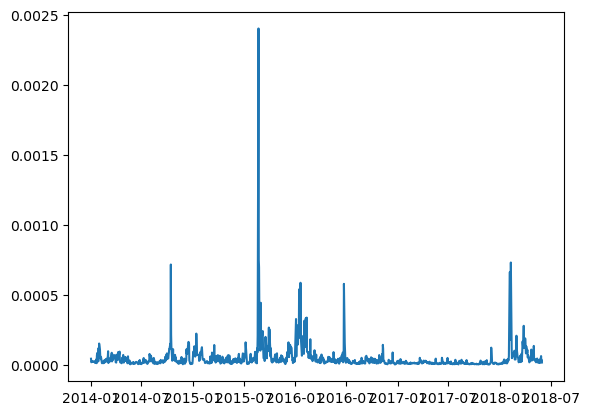

In [21]:
plt.plot(rv)

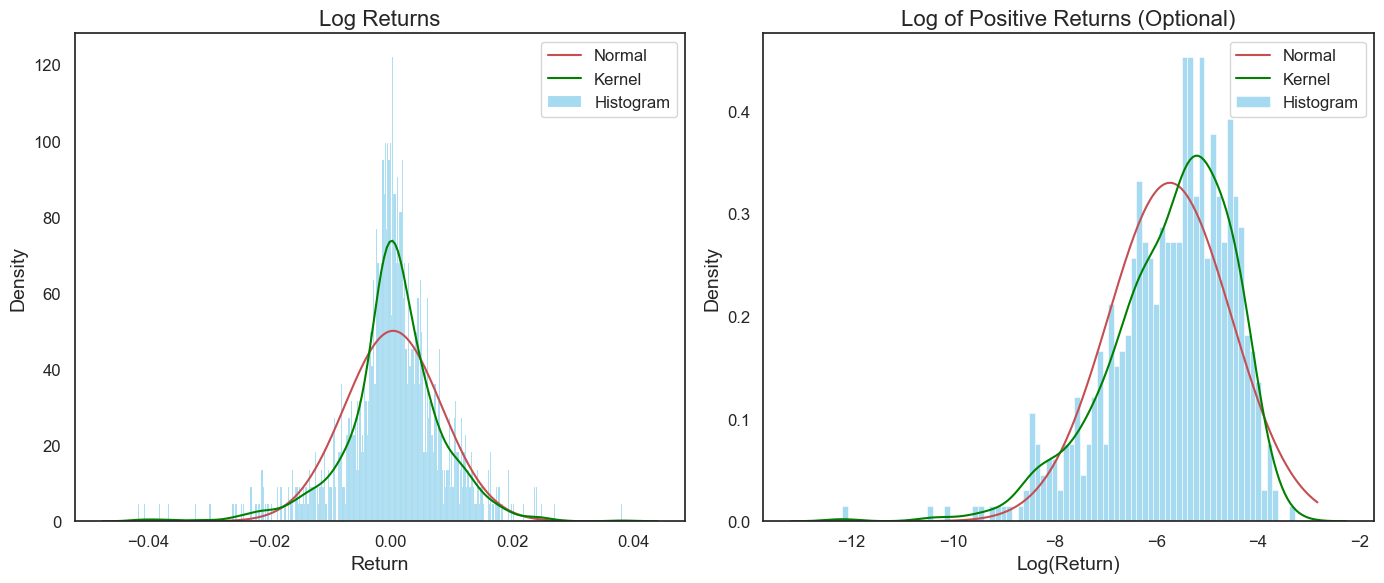

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Prepare data
rtn = np.log(df['close_price']).diff().dropna()
log_rtn = np.log(rtn[rtn > 0])  # optional, if you want to still look at log of positive returns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Return histogram and density curves
sns.histplot(rtn, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rtn.min(), rtn.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the normal distribution
mu_rtn, std_rtn = norm.fit(rtn)
ax[0].plot(x_vals, norm.pdf(x_vals, mu_rtn, std_rtn), 'r', label='Normal')

# Add kernel density estimate
sns.kdeplot(rtn, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Log Returns', fontsize=16)
ax[0].set_xlabel('Return', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log of positive returns (optional, for exploration)
sns.histplot(log_rtn, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rtn)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rtn, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log of Positive Returns (Optional)', fontsize=16)
ax[1].set_xlabel('Log(Return)', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Autocorrelation

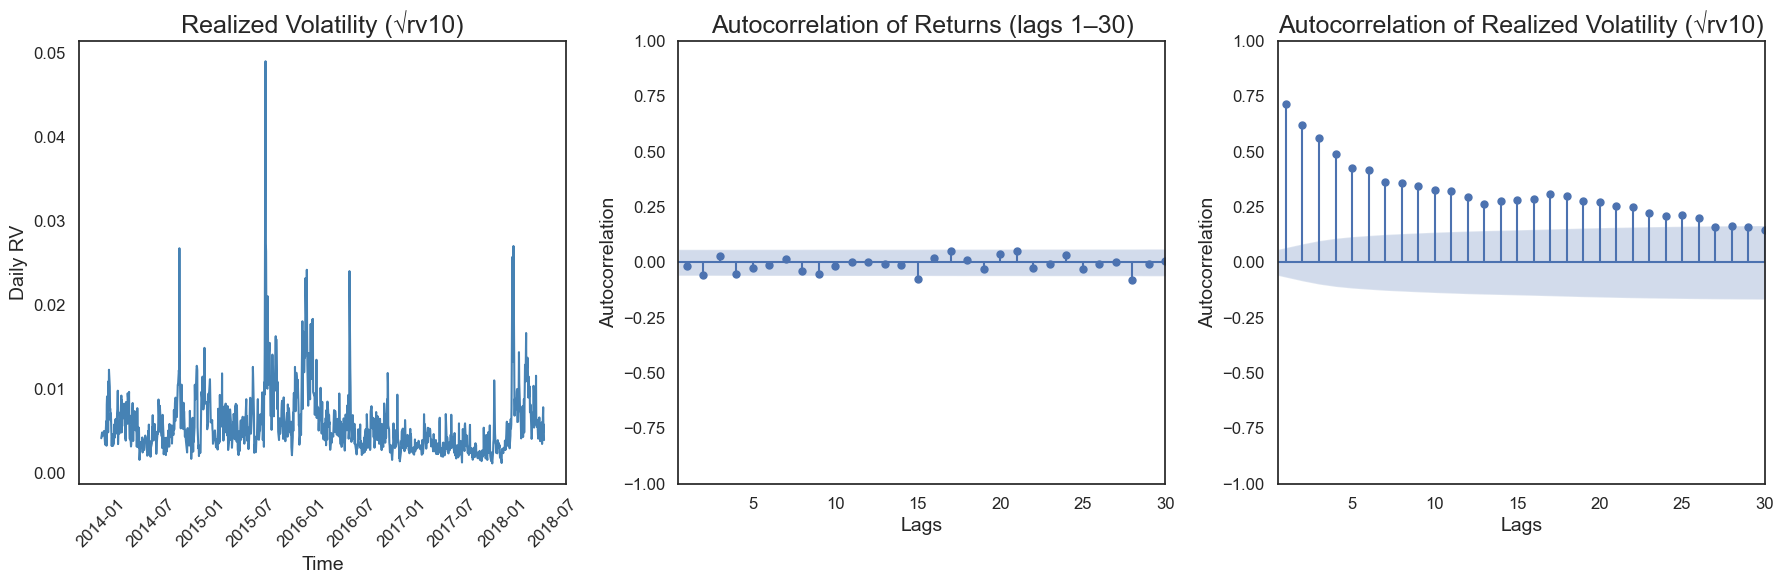

In [6]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=18)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=18)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=18)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()